In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/Comp4211_project/Project
%ls

/content/drive/MyDrive/Comp4211_project/Project
classifier/       config.py  CycleGAN_save/  dataset/         __pycache__/  test.ipynb
Classifier_save/  cyclegan/  data/           inference.ipynb  samples/      train.py


In [12]:
import torch
from classifier.classifier import Classifier
from data.dataloader import DataLoader_Classifier
from config import opt
import os
import numpy as np
import matplotlib.pyplot as plt
opt = opt()


In [6]:
netC = Classifier(input_size=64)
save_path = opt.classifier_save_path
check_point = 50
name_type = opt.name_T
netC.load_state_dict(torch.load(os.path.join(save_path, f"{name_type}/netC_{check_point}.pth")))
netC.eval()
netC.cuda()

dataloader = DataLoader_Classifier(img_size=64)
labels_name = dataloader.get_labels_names()
idx_to_class = {v: k for k, v in labels_name.items()}
print(idx_to_class)

{0: 'lung_aca', 1: 'lung_n', 2: 'lung_scc'}


In [7]:
from cyclegan.cyclegan import cycleG

netG_aca_n = cycleG()
netG_scc_n = cycleG()
netG_aca_scc = cycleG()
# Load the model
check_point_aca_n = 25
check_point_scc_n = 25
check_point_aca_scc = 35
save_path = opt.gan_save_path
name_type = opt.name_T

name_A = 'lung_aca'
name_B = 'lung_n'
name_C = 'lung_scc'

netG_aca_n.load_state_dict(torch.load(os.path.join(save_path, f"generator/{name_type}/{name_A}_and_{name_B}/netG_{check_point_aca_n}.pth")))
netG_scc_n.load_state_dict(torch.load(os.path.join(save_path, f"generator/{name_type}/{name_C}_and_{name_B}/netG_{check_point_scc_n}.pth")))
netG_aca_scc.load_state_dict(torch.load(os.path.join(save_path, f"generator/{name_type}/{name_A}_and_{name_C}/netG_{check_point_aca_scc}.pth")))

netG_aca_n.eval().cuda()
netG_scc_n.eval().cuda()
netG_aca_scc.eval().cuda()

cycleG(
  (generator_A_to_B): Generator(
    (model): Unet(
      (image_proj): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (down): ModuleList(
        (0): Downsample(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        (1-2): 2 x DownBlock(
          (res): ResidualBlock(
            (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
            (act1): Swish()
            (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
            (act2): Swish()
            (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (shortcut): Identity()
          )
        )
        (3): Downsample(
          (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        )
        (4): DownBlock(
          (res): ResidualBlock(
            (norm1): GroupNorm(32, 64, eps=1e-05, affine=Tru

In [16]:
from PIL import Image
import torchvision.transforms as transforms

def transform (size):
  return transforms.Compose([
    transforms.Resize((size, size)),
    transforms.ToTensor(),
])

def inference(image_path, netC, netG_aca_n, netG_aca_scc, netG_scc_n, idx_to_class):
    raw_image = Image.open(image_path).convert('RGB')
    raw_image.show()
    
    image = transform(64)(raw_image).unsqueeze(0)
    if torch.cuda.is_available():
        image = image.cuda()

    output = netC(image)
    _, predicted = torch.max(output.data, 1)
    predicted_class = idx_to_class[predicted.item()]
    
    print(f"Predicted class: {predicted_class}")

    image = transform(96)(raw_image).unsqueeze(0)
    if torch.cuda.is_available():
        image = image.cuda()
    
    blank = torch.zeros(1, 3, 96, 96)
    if torch.cuda.is_available():
        blank = blank.cuda()

    match predicted_class:
        case 'lung_aca':
            image_aca = image
            _, image_n = netG_aca_n(image, blank)
            _, image_scc = netG_aca_scc(image, blank)
        case 'lung_scc':
            image_scc = image
            _, image_n = netG_scc_n(image, blank)
            image_aca, _ = netG_aca_scc(blank, image)
        case 'lung_n':
            image_n = image
            image_aca, _ = netG_aca_n(blank, image)
            image_scc, _ = netG_scc_n(blank, image)

    image_aca = image_aca.cpu().detach().numpy()
    image_n = image_n.cpu().detach().numpy()
    image_scc = image_scc.cpu().detach().numpy()

    image_aca = np.transpose(image_aca, (0, 2, 3, 1))
    image_n = np.transpose(image_n, (0, 2, 3, 1))
    image_scc = np.transpose(image_scc, (0, 2, 3, 1))

    plt.figure(figsize=(10, 10))

    plt.subplot(3, 1, 1)
    plt.imshow(image_n[0])
    plt.title('n (real)' if predicted_class == 'lung_n' else 'n (fake)')

    plt.subplot(3, 1, 2)
    plt.imshow(image_aca[0])
    plt.title('aca (real)' if predicted_class == 'lung_aca' else 'aca (fake)')

    plt.subplot(3, 1, 3)
    plt.imshow(image_scc[0])
    plt.title('scc (real)' if predicted_class == 'lung_scc' else 'scc (fake)')

    plt.show()





In [17]:
# transform = transforms.Compose([
#     transforms.Resize((96, 96)),
#     transforms.ToTensor(),
# ])

# # Load the image
# image_path = "/content/drive/MyDrive/Comp4211_tempt/Project/lungaca10.jpeg（副本）"
# image = Image.open(image_path).convert('RGB')


# # Apply the transformation
# image = transform(image).unsqueeze(0).cuda()
# blank =  torch.zeros(1,3,96,96).cuda()
# _, guess = netG(image, blank)
# guess = guess.cpu().detach().numpy()
# image = image.cpu().detach().numpy()


# guess = np.transpose(guess, (0, 2, 3, 1))
# image = np.transpose(image, (0, 2, 3, 1))



# plt.figure(figsize=(10, 10))

# plt.subplot(2, 1, 1)
# plt.imshow(image[0])
# plt.title('Real A')

# plt.subplot(2, 1, 2)
# plt.imshow(guess[0])
# plt.title('Fake B')




(eog:1985094): Gtk-WARNING **: 10:48:39.623: cannot open display: 
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Predicted class: lung_aca


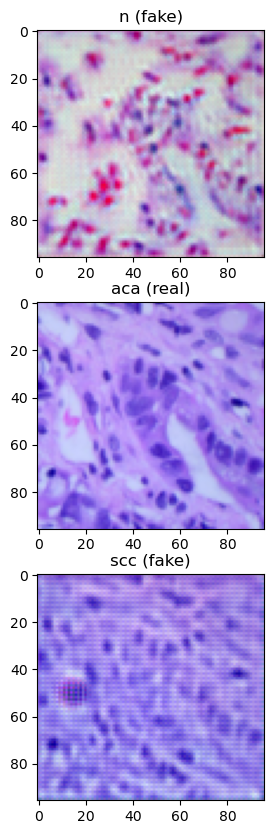

In [19]:
img_path = './dataset/lung/lung_aca/lungaca11.jpeg'

inference(img_path, netC, netG_aca_n, netG_aca_scc, netG_scc_n, idx_to_class)